In [1]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from matplotlib import pyplot as plt
import autograd.numpy as npa

/home/vincent/mambaforge/envs/meep/lib/python3.11/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/vincent/mambaforge/envs/meep/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/vincent/mambaforge/envs/meep/lib/python3.11/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/vincent/mambaforge/envs/meep/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [2]:
pml_size = 1.0  # (μm)

dx = 0.02
opt_size_x = 101 * dx
opt_size_y = 181 * dx
size_x = 2.6 + pml_size  # um
size_y = 4.5 + pml_size  # um

out_wg_dist = 1.25
wg_width = 0.5
mode_width = 3*wg_width
wg_index = 2.8
bg_index = 1.44

source_x = -size_x/2 - 0.1
source_y = 0
source_yspan = mode_width
source_z = 0
center_wavelength = 1.550


Si = mp.Medium(index=wg_index)
SiO2 = mp.Medium(index=bg_index)
# size of a pixel (in μm) 20 nm in lumerical exp
delta = dx
# resolution = 20 # (pixels/μm)
resolution = 1/delta  # pixels/μm
waveguide_width = wg_width  # 0.5 # (μm)
design_region_width = opt_size_x  # (μm)
design_region_height = opt_size_y  # (μm)
arm_separation = out_wg_dist  # 1.0 (μm) distance between arms center to center
# waveguide_length = source_wg_xmax - source_wg_xmin  # 0.5 (μm)

# ## Design variable setup

minimum_length = 0.09  # (μm)
eta_e = 0.75
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)  # (μm)
eta_i = 0.5
eta_d = 1-eta_e
design_region_resolution = int(resolution)  # int(4*resolution) # (pixels/μm)
frequencies = 1/np.linspace(1.5, 1.6, 5)  # (1/μm)

Nx = int(design_region_resolution*design_region_width)
Ny = int(design_region_resolution*design_region_height)

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), SiO2, Si)
size = mp.Vector3(design_region_width, design_region_height)
volume = mp.Volume(center=mp.Vector3(), size=size)
design_region = mpa.DesignRegion(design_variables, volume=volume)

# ## Simulation Setup

Sx = 2*pml_size + size_x  # cell size in X
Sy = 2*pml_size + size_y  # cell size in Y
cell_size = mp.Vector3(Sx, Sy)

pml_layers = [mp.PML(pml_size)]

fcen = 1/center_wavelength  # 1/1.55
width = 0.2
fwidth = width * fcen
source_center = [source_x, source_y, source_z]

source_size = mp.Vector3(0, source_yspan, 0)
kpoint = mp.Vector3(1, 0, 0)
src = mp.GaussianSource(frequency=fcen, fwidth=fwidth)

     block, center = (-1.4,0,0)
          size (3.8,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (7.84,7.84,7.84)
     block, center = (1.4,1.25,0)
          size (3.8,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (7.84,7.84,7.84)
     block, center = (1.4,-1.25,0)
          size (3.8,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (7.84,7.84,7.84)
     block, center = (0,0,0)
          size (2.02,3.62,0)
          axes (1,0,0), (0,1,0), (0,0,1)


<Axes: xlabel='X', ylabel='Y'>

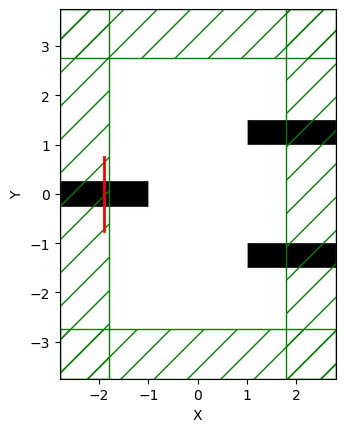

In [3]:
fwidth = width * fcen
source_center  = [source_x, source_y, source_z]
# source_center  = [-Sx/2 + pml_size + waveguide_length/3,0,0]

source_size = mp.Vector3(0,source_yspan, 0) #mp.Vector3(0,2,0)
kpoint = mp.Vector3(1,0,0)
src = mp.GaussianSource(frequency=fcen,fwidth=fwidth)
# src = mp.GaussianSource(frequency=fcen)
source = [mp.EigenModeSource(src,
                            eig_band=1,
                            direction=mp.NO_DIRECTION,
                            eig_kpoint=kpoint,
                            size=source_size,
                            center=source_center,
                            eig_parity=mp.EVEN_Z+mp.ODD_Y)]
mon_pt = mp.Vector3(*source_center)


geometry = [
    mp.Block(center=mp.Vector3(x=-Sx/4), material=Si, size=mp.Vector3(Sx/2+1, waveguide_width, 0)), # left waveguide
    mp.Block(center=mp.Vector3(x=Sx/4, y=arm_separation), material=Si, size=mp.Vector3(Sx/2+1, waveguide_width, 0)), # top right waveguide
    mp.Block(center=mp.Vector3(x=Sx/4, y=-arm_separation), material=Si, size=mp.Vector3(Sx/2+1, waveguide_width, 0)), # bottom right waveguide
    mp.Block(center=design_region.center, size=design_region.size, material=design_variables)
]

sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=source,
                    #symmetries=[mp.Mirror(direction=mp.Y)],
                    default_material=SiO2,
                    resolution=resolution)
sim.plot2D()

In [4]:
def mapping(x,eta,beta):
    x = (npa.fliplr(x.reshape(Nx,Ny)) + x.reshape(Nx,Ny))/2 # up-down symmetry
    # filter
    filtered_field = mpa.conic_filter(x,
        filter_radius,design_region_width,design_region_height,design_region_resolution)
    # projection
    projected_field = mpa.tanh_projection(filtered_field,beta,eta)
    # interpolate to actual materials
    return projected_field.flatten()

     block, center = (-1.4,0,0)
          size (3.8,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (7.84,7.84,7.84)
     block, center = (1.4,1.25,0)
          size (3.8,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (7.84,7.84,7.84)
     block, center = (1.4,-1.25,0)
          size (3.8,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (7.84,7.84,7.84)
     block, center = (0,0,0)
          size (2.02,3.62,0)
          axes (1,0,0), (0,1,0), (0,0,1)


<Axes: xlabel='X', ylabel='Y'>

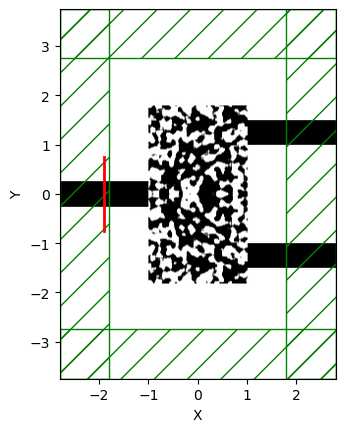

In [5]:
design_region.update_design_parameters(mapping(np.random.rand(Nx,Ny),0.5,256))
sim.plot2D()

     block, center = (-1.4,0,0)
          size (3.8,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (7.84,7.84,7.84)
     block, center = (1.4,1.25,0)
          size (3.8,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (7.84,7.84,7.84)
     block, center = (1.4,-1.25,0)
          size (3.8,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (7.84,7.84,7.84)
     block, center = (0,0,0)
          size (2.02,3.62,0)
          axes (1,0,0), (0,1,0), (0,0,1)


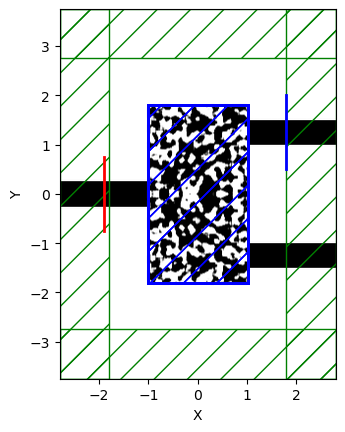

: 

In [6]:
mode = 1
monsize = mp.Vector3(y=3*waveguide_width)
topmoncenter = mp.Vector3(size_x/2, arm_separation, 0)
topfluxregion = mp.FluxRegion(topmoncenter, monsize)
TE_top = mpa.EigenmodeCoefficient(sim,
        mp.Volume(center=topmoncenter,size=monsize),mode)
def J2(top):
    power = npa.abs(top) ** 2 
    return npa.mean(power)

ob_list = [TE_top]


opt = mpa.OptimizationProblem(
    simulation = sim,
    objective_functions = J2,
    objective_arguments = ob_list,
    design_regions = [design_region],
    frequencies=frequencies
)
opt.plot2D(True)


In [ ]:
x0 = 0.5*np.ones((Nx,Ny))
f0, g0 = opt([mapping(x0,0.5,2)])
plt.figure()
print(g0.shape)
plt.imshow(np.rot90(g0[:,0].reshape(Nx,Ny)))
plt.colorbar()

Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000344038 s
Working in 2D dimensions.
Computational cell is 5.6 x 7.5 x 0 with resolution 50
     block, center = (-1.4,0,0)
          size (3.8,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (7.84,7.84,7.84)
     block, center = (1.4,1.25,0)
          size (3.8,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (7.84,7.84,7.84)
     block, center = (1.4,-1.25,0)
          size (3.8,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (7.84,7.84,7.84)
     block, center = (0,0,0)
          size (2.02,3.62,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.241457 s
-----------
MPB solved for frequency_1(1,0,0) = 0.461434 after 10 iters
MPB solved for frequency_1(1.5726,0,0) = 0.644665 after 7 iters
MPB solved for frequency_1(1.57414,0,0)

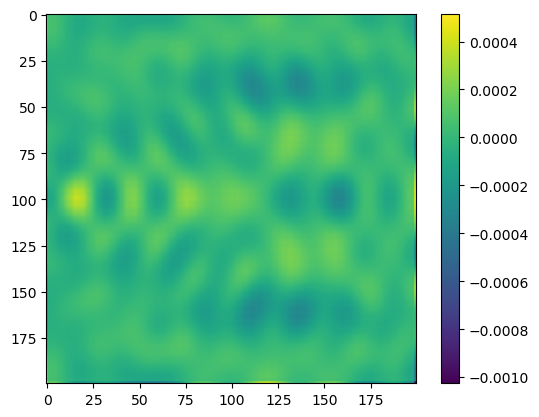

In [ ]:
from autograd import tensor_jacobian_product
backprop_gradient = tensor_jacobian_product(mapping,0)(x0,0.5,2,g0[:,0])
plt.imshow(np.rot90(backprop_gradient.reshape(Nx,Ny)))
plt.colorbar()